<a href="https://colab.research.google.com/github/nomchanz/graduation_thesis_new/blob/main/forwardNN_n250_rawdata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
# 必要なライブラリのimport
import csv
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Input, concatenate
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

In [34]:
# データの準備、読み込み


## データファイルのpath(位置データはrawの方)
no_hole_path = 'no_hole_data.csv'
one_hole_size_path = 'one_hole_size_data.csv'
one_hole_position_path = 'one_hole_position_data_raw.csv'
four_holes_size_path = 'four_holes_size_data.csv'
four_holes_position_path = 'four_holes_position_data_raw.csv'
nine_holes_size_path = 'nine_holes_size_data.csv'
nine_holes_position_path = 'nine_holes_position_data_raw.csv'
sixteen_holes_size_path = 'sixteen_holes_size_data.csv'
sixteen_holes_position_path = 'sixteen_holes_position_data_raw.csv'
twentyfive_holes_size_path = 'twentyfive_holes_size_data.csv'
twentyfive_holes_position_path = 'twentyfive_holes_position_data_raw.csv'


## csvファイルをリスト化

### 穴なしの温度分布データ
with open(no_hole_path) as f0:
  lst_f0 = list(csv.reader(f0))
lst_f0 = [r[:-1] for r in lst_f0]

### 大きさに関するデータ
with open(one_hole_size_path) as fs1:
  lst_fs1 = list(csv.reader(fs1))
with open(four_holes_size_path) as fs2:
  lst_fs2 = list(csv.reader(fs2))
with open(nine_holes_size_path) as fs3:
  lst_fs3 = list(csv.reader(fs3))
with open(sixteen_holes_size_path) as fs4:
  lst_fs4 = list(csv.reader(fs4))
with open(twentyfive_holes_size_path) as fs5:
  lst_fs5 = list(csv.reader(fs5))

### 位置に関するデータ
with open(one_hole_position_path) as fp1:
  lst_fp1 = list(csv.reader(fp1))
with open(four_holes_position_path) as fp2:
  lst_fp2 = list(csv.reader(fp2))
with open(nine_holes_position_path) as fp3:
  lst_fp3 = list(csv.reader(fp3))
with open(sixteen_holes_position_path) as fp4:
  lst_fp4 = list(csv.reader(fp4))
with open(twentyfive_holes_position_path) as fp5:
  lst_fp5 = list(csv.reader(fp5))

In [35]:
# model_1

# データの前処理


## 変数設定(各条件を変えてたくさん試すため)
n = 250                    #nは総抽出データ数
train = 0.8                 #train:validのtrainデータの割合
seed = 0                       
random.seed(seed)           #乱数seed固定


## データ加工

### データ抽出(各データをランダムにシャッフル→train,valid,testに分割。各大きさのデータが同じ数だけ抽出される。)
for i in range (1,6):
  exec("lst_fs"+str(i)+"_shuffle = random.sample(lst_fs"+str(i)+", len(lst_fs"+str(i)+"))")  
  exec("lst_fs"+str(i)+"_train = lst_fs"+str(i)+"_shuffle[0:"+str(int(n/5*train))+"]")       
  exec("lst_fs"+str(i)+"_valid = lst_fs"+str(i)+"_shuffle["+str(int(n/5*train))+":"+str(int(n/5))+"]")          
  exec("lst_fs"+str(i)+"_test = lst_fs"+str(i)+"_shuffle["+str(int(n/5))+":-1]")
  exec("lst_fp"+str(i)+"_shuffle = random.sample(lst_fp"+str(i)+", len(lst_fp"+str(i)+"))")
  exec("lst_fp"+str(i)+"_train = lst_fp"+str(i)+"_shuffle[0:"+str(int(n/5*train))+"]")
  exec("lst_fp"+str(i)+"_valid = lst_fp"+str(i)+"_shuffle["+str(int(n/5*train))+":"+str(int(n/5))+"]") 
  exec("lst_fp"+str(i)+"_test = lst_fp"+str(i)+"_shuffle["+str(int(n/5))+":-1]")

### train,valid,testの各々について、大きさ、位置、表面温度分布データに分割
for i in range (1,6):
  exec("lst_x_fs"+str(i)+"_train = [r[0] for r in lst_fs"+str(i)+"_train]")
  exec("lst_x_fp"+str(i)+"_train = [r[0:2] for r in lst_fp"+str(i)+"_train]")
  exec("lst_y"+str(i)+"_train = [r[2:-1] for r in lst_fp"+str(i)+"_train]")
  exec("lst_x_fs"+str(i)+"_valid = [r[0] for r in lst_fs"+str(i)+"_valid]")
  exec("lst_x_fp"+str(i)+"_valid = [r[0:2] for r in lst_fp"+str(i)+"_valid]")
  exec("lst_y"+str(i)+"_valid = [r[2:-1] for r in lst_fp"+str(i)+"_valid]")
  exec("lst_x_fs"+str(i)+"_test = [r[0] for r in lst_fs"+str(i)+"_test]")
  exec("lst_x_fp"+str(i)+"_test = [r[0:2] for r in lst_fp"+str(i)+"_test]")
  exec("lst_y"+str(i)+"_test = [r[2:-1] for r in lst_fp"+str(i)+"_test]")

### データを結合(入力データ・正解データの大枠完成)
lst_x_fs_train = lst_x_fs1_train + lst_x_fs2_train + lst_x_fs3_train + lst_x_fs4_train + lst_x_fs5_train
lst_x_fp_train = lst_x_fp1_train + lst_x_fp2_train + lst_x_fp3_train + lst_x_fp4_train + lst_x_fp5_train
lst_y_train = lst_y1_train + lst_y2_train + lst_y3_train + lst_y4_train + lst_y5_train

lst_x_fs_valid = lst_x_fs1_valid + lst_x_fs2_valid + lst_x_fs3_valid + lst_x_fs4_valid + lst_x_fs5_valid
lst_x_fp_valid = lst_x_fp1_valid + lst_x_fp2_valid + lst_x_fp3_valid + lst_x_fp4_valid + lst_x_fp5_valid
lst_y_valid = lst_y1_valid + lst_y2_valid + lst_y3_valid + lst_y4_valid + lst_y5_valid

lst_x_fs_test = lst_x_fs1_test + lst_x_fs2_test + lst_x_fs3_test + lst_x_fs4_test + lst_x_fs5_test
lst_x_fp_test = lst_x_fp1_test + lst_x_fp2_test + lst_x_fp3_test + lst_x_fp4_test + lst_x_fp5_test
lst_y_test = lst_y1_test + lst_y2_test + lst_y3_test + lst_y4_test + lst_y5_test

### np.arrayで変換
lst_f0 = np.array(lst_f0, dtype=float)
lst_x_fs_train = np.array(lst_x_fs_train, dtype=int)
lst_x_fp_train = np.array(lst_x_fp_train, dtype=int)
lst_x_fs_valid = np.array(lst_x_fs_valid, dtype=int)
lst_x_fp_valid = np.array(lst_x_fp_valid, dtype=int)
lst_x_fs_test = np.array(lst_x_fs_test, dtype=int)
lst_x_fp_test = np.array(lst_x_fp_test, dtype=int)
lst_y_train = np.array(lst_y_train, dtype=float)
lst_y_valid = np.array(lst_y_valid, dtype=float)
lst_y_test = np.array(lst_y_test, dtype=float)

### 大きさデータを二次元化
x_fs_train = lst_x_fs_train.reshape(-1, 1)
x_fs_valid = lst_x_fs_valid.reshape(-1, 1)
x_fs_test = lst_x_fs_test.reshape(-1, 1)


### 温度分布データを、穴なし温度分布データとの差に変換
y_train = lst_y_train - lst_f0
y_valid = lst_y_valid - lst_f0
y_test = lst_y_test - lst_f0

### 入力データの正規化
scaler_x = MinMaxScaler()
x_fs_train_n = scaler_x.fit_transform(x_fs_train)
x_fs_valid_n = scaler_x.fit_transform(x_fs_valid)
x_fs_test_n = scaler_x.fit_transform(x_fs_test) 
x_fp_train_n = scaler_x.fit_transform(lst_x_fp_train)
x_fp_valid_n = scaler_x.fit_transform(lst_x_fp_valid)
x_fp_test_n = scaler_x.fit_transform(lst_x_fp_test) 

In [36]:
lst_x_fp_train.shape

(200, 2)

In [37]:
# NN

## 入力を定義
input1 = Input(shape=(1,))
input2 = Input(shape=(2,))

## 入力1から結合前まで
x = Dense(1, activation="linear")(input1)
x = Model(inputs=input1, outputs=x)

## 入力2から結合前まで
y = Dense(2, activation="linear")(input2)
y = Model(inputs=input2, outputs=y)

## 結合
combined = concatenate([x.output, y.output])

## 密結合
z = Dense(32, activation="relu")(combined)
z = Dense(512, activation="relu")(z)
z = Dense(256, activation="relu")(z)
z = Dense(128, activation="relu")(z)
z = Dense(50)(z)

# モデル定義とコンパイル
model_1 = Model(inputs=[x.input, y.input], outputs=z)
model_1.compile(loss='mse', optimizer='adam', metrics=['mae'])

In [38]:
# 学習
epochs = 2000
batch_size = 32
history_1 = model_1.fit([x_fs_train_n, x_fp_train_n], y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=([x_fs_valid_n, x_fp_valid_n], y_valid))

Epoch 1/2000
7/7 [==============================] - 1s 37ms/step - loss: 0.4111 - mae: 0.2916 - val_loss: 0.2108 - val_mae: 0.2065
Epoch 2/2000
7/7 [==============================] - 0s 11ms/step - loss: 0.3235 - mae: 0.2154 - val_loss: 0.1915 - val_mae: 0.1840
Epoch 3/2000
7/7 [==============================] - 0s 10ms/step - loss: 0.1956 - mae: 0.1873 - val_loss: 0.1808 - val_mae: 0.1598
Epoch 4/2000
7/7 [==============================] - 0s 10ms/step - loss: 0.3523 - mae: 0.1875 - val_loss: 0.1735 - val_mae: 0.1498
Epoch 5/2000
7/7 [==============================] - 0s 12ms/step - loss: 0.3548 - mae: 0.1774 - val_loss: 0.1682 - val_mae: 0.1349
Epoch 6/2000
7/7 [==============================] - 0s 12ms/step - loss: 0.2495 - mae: 0.1475 - val_loss: 0.1631 - val_mae: 0.1310
Epoch 7/2000
7/7 [==============================] - 0s 11ms/step - loss: 0.2190 - mae: 0.1493 - val_loss: 0.1623 - val_mae: 0.1318
Epoch 8/2000
7/7 [==============================] - 0s 11ms/step - loss: 0.2661 - m

In [39]:
# モデルの評価
score = model_1.evaluate([x_fs_test_n, x_fp_test_n], y_test, verbose=1)
print('Test loss:', score[0])
print('Test mae:', score[1])

309/309 [==============================] - 0s 1ms/step - loss: 0.1154 - mae: 0.0636
Test loss: 0.11539225280284882
Test mae: 0.06360097974538803


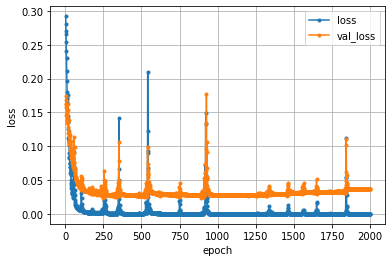

In [40]:
# 学習経過の可視化
loss     = history_1.history['loss']
val_loss = history_1.history['val_loss']

nb_epoch = len(loss)
for i in range(50):
  if max(loss)>0.3: 
    if i == 49:
      plt.plot(range(i,nb_epoch), loss, marker='.', label='loss')
      plt.plot(range(i,nb_epoch), val_loss, marker='.', label='val_loss')
      break
    else:
      loss = loss[1:]
      val_loss = val_loss[1:]
  else:
    plt.plot(range(i,nb_epoch), loss, marker='.', label='loss')
    plt.plot(range(i,nb_epoch), val_loss, marker='.', label='val_loss')
    break
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

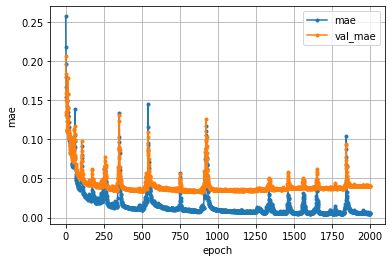

In [41]:
# 学習経過の可視化
mae     = history_1.history['mae']
val_mae = history_1.history['val_mae']

nb_epoch = len(mae)
for i in range(50):
  if max(mae)>0.3: 
    if i == 49:
      plt.plot(range(i,nb_epoch), mae, marker='.', label='mae')
      plt.plot(range(i,nb_epoch), val_mae, marker='.', label='val_mae')
      break
    else:
      mae = mae[1:]
      val_mae = val_mae[1:]
  else:
    plt.plot(range(i,nb_epoch), mae, marker='.', label='mae')
    plt.plot(range(i,nb_epoch), val_mae, marker='.', label='val_mae')
    break
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('mae')
plt.show()

In [42]:
# 学習モデルの保存
model_1.save(str(n)+"_random.seed("+str(seed)+")_train"+str(train)+"_raw.h5")

In [43]:
# model_2

# データの前処理


## 変数設定(各条件を変えてたくさん試すため)
train = 0.5                 #train:validのtrainデータの割合                      
random.seed(seed)           #乱数seed固定


## データ加工

### データ抽出(各データをランダムにシャッフル→train,valid,testに分割。各大きさのデータが同じ数だけ抽出される。)
for i in range (1,6):
  exec("lst_fs"+str(i)+"_shuffle = random.sample(lst_fs"+str(i)+", len(lst_fs"+str(i)+"))")  
  exec("lst_fs"+str(i)+"_train = lst_fs"+str(i)+"_shuffle[0:"+str(int(n/5*train))+"]")       
  exec("lst_fs"+str(i)+"_valid = lst_fs"+str(i)+"_shuffle["+str(int(n/5*train))+":"+str(int(n/5))+"]")          
  exec("lst_fs"+str(i)+"_test = lst_fs"+str(i)+"_shuffle["+str(int(n/5))+":-1]")
  exec("lst_fp"+str(i)+"_shuffle = random.sample(lst_fp"+str(i)+", len(lst_fp"+str(i)+"))")
  exec("lst_fp"+str(i)+"_train = lst_fp"+str(i)+"_shuffle[0:"+str(int(n/5*train))+"]")
  exec("lst_fp"+str(i)+"_valid = lst_fp"+str(i)+"_shuffle["+str(int(n/5*train))+":"+str(int(n/5))+"]") 
  exec("lst_fp"+str(i)+"_test = lst_fp"+str(i)+"_shuffle["+str(int(n/5))+":-1]")

### train,valid,testの各々について、大きさ、位置、表面温度分布データに分割
for i in range (1,6):
  exec("lst_x_fs"+str(i)+"_train = [r[0] for r in lst_fs"+str(i)+"_train]")
  exec("lst_x_fp"+str(i)+"_train = [r[0:2] for r in lst_fp"+str(i)+"_train]")
  exec("lst_y"+str(i)+"_train = [r[2:-1] for r in lst_fp"+str(i)+"_train]")
  exec("lst_x_fs"+str(i)+"_valid = [r[0] for r in lst_fs"+str(i)+"_valid]")
  exec("lst_x_fp"+str(i)+"_valid = [r[0:2] for r in lst_fp"+str(i)+"_valid]")
  exec("lst_y"+str(i)+"_valid = [r[2:-1] for r in lst_fp"+str(i)+"_valid]")
  exec("lst_x_fs"+str(i)+"_test = [r[0] for r in lst_fs"+str(i)+"_test]")
  exec("lst_x_fp"+str(i)+"_test = [r[0:2] for r in lst_fp"+str(i)+"_test]")
  exec("lst_y"+str(i)+"_test = [r[2:-1] for r in lst_fp"+str(i)+"_test]")

### データを結合(入力データ・正解データの大枠完成)
lst_x_fs_train = lst_x_fs1_train + lst_x_fs2_train + lst_x_fs3_train + lst_x_fs4_train + lst_x_fs5_train
lst_x_fp_train = lst_x_fp1_train + lst_x_fp2_train + lst_x_fp3_train + lst_x_fp4_train + lst_x_fp5_train
lst_y_train = lst_y1_train + lst_y2_train + lst_y3_train + lst_y4_train + lst_y5_train

lst_x_fs_valid = lst_x_fs1_valid + lst_x_fs2_valid + lst_x_fs3_valid + lst_x_fs4_valid + lst_x_fs5_valid
lst_x_fp_valid = lst_x_fp1_valid + lst_x_fp2_valid + lst_x_fp3_valid + lst_x_fp4_valid + lst_x_fp5_valid
lst_y_valid = lst_y1_valid + lst_y2_valid + lst_y3_valid + lst_y4_valid + lst_y5_valid

lst_x_fs_test = lst_x_fs1_test + lst_x_fs2_test + lst_x_fs3_test + lst_x_fs4_test + lst_x_fs5_test
lst_x_fp_test = lst_x_fp1_test + lst_x_fp2_test + lst_x_fp3_test + lst_x_fp4_test + lst_x_fp5_test
lst_y_test = lst_y1_test + lst_y2_test + lst_y3_test + lst_y4_test + lst_y5_test

### np.arrayで変換
lst_f0 = np.array(lst_f0, dtype=float)
lst_x_fs_train = np.array(lst_x_fs_train, dtype=int)
lst_x_fp_train = np.array(lst_x_fp_train, dtype=int)
lst_x_fs_valid = np.array(lst_x_fs_valid, dtype=int)
lst_x_fp_valid = np.array(lst_x_fp_valid, dtype=int)
lst_x_fs_test = np.array(lst_x_fs_test, dtype=int)
lst_x_fp_test = np.array(lst_x_fp_test, dtype=int)
lst_y_train = np.array(lst_y_train, dtype=float)
lst_y_valid = np.array(lst_y_valid, dtype=float)
lst_y_test = np.array(lst_y_test, dtype=float)

### 入力データを二次元化
x_fs_train = lst_x_fs_train.reshape(-1, 1)
x_fs_valid = lst_x_fs_valid.reshape(-1, 1)
x_fs_test = lst_x_fs_test.reshape(-1, 1)

### 温度分布データを、穴なし温度分布データとの差に変換
y_train = lst_y_train - lst_f0
y_valid = lst_y_valid - lst_f0
y_test = lst_y_test - lst_f0

### 入力データの正規化
scaler_x = MinMaxScaler()
x_fs_train_n = scaler_x.fit_transform(x_fs_train)
x_fs_valid_n = scaler_x.fit_transform(x_fs_valid)
x_fs_test_n = scaler_x.fit_transform(x_fs_test) 
x_fp_train_n = scaler_x.fit_transform(lst_x_fp_train)
x_fp_valid_n = scaler_x.fit_transform(lst_x_fp_valid)
x_fp_test_n = scaler_x.fit_transform(lst_x_fp_test) 

In [44]:
# NN

## 入力を定義
input1 = Input(shape=(1,))
input2 = Input(shape=(2,))

## 入力1から結合前まで
x = Dense(1, activation="linear")(input1)
x = Model(inputs=input1, outputs=x)

## 入力2から結合前まで
y = Dense(2, activation="linear")(input2)
y = Model(inputs=input2, outputs=y)

## 結合
combined = concatenate([x.output, y.output])

## 密結合
z = Dense(32, activation="relu")(combined)
z = Dense(512, activation="relu")(z)
z = Dense(256, activation="relu")(z)
z = Dense(128, activation="relu")(z)
z = Dense(50)(z)

## モデル定義とコンパイル
model_2 = Model(inputs=[x.input, y.input], outputs=z)
model_2.compile(loss='mse', optimizer='adam', metrics=['mae'])

In [45]:
# 学習
epochs = 2000
batch_size = 32
history_2 = model_2.fit([x_fs_train_n, x_fp_train_n], y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=([x_fs_valid_n, x_fp_valid_n], y_valid))

Epoch 1/2000
4/4 [==============================] - 1s 68ms/step - loss: 0.4222 - mae: 0.3127 - val_loss: 0.1492 - val_mae: 0.2083
Epoch 2/2000
4/4 [==============================] - 0s 19ms/step - loss: 0.4521 - mae: 0.2914 - val_loss: 0.1410 - val_mae: 0.1985
Epoch 3/2000
4/4 [==============================] - 0s 18ms/step - loss: 0.4456 - mae: 0.2924 - val_loss: 0.1336 - val_mae: 0.1881
Epoch 4/2000
4/4 [==============================] - 0s 19ms/step - loss: 0.4047 - mae: 0.2542 - val_loss: 0.1283 - val_mae: 0.1797
Epoch 5/2000
4/4 [==============================] - 0s 22ms/step - loss: 0.4072 - mae: 0.2468 - val_loss: 0.1257 - val_mae: 0.1769
Epoch 6/2000
4/4 [==============================] - 0s 18ms/step - loss: 0.4410 - mae: 0.2584 - val_loss: 0.1222 - val_mae: 0.1745
Epoch 7/2000
4/4 [==============================] - 0s 20ms/step - loss: 0.4765 - mae: 0.2619 - val_loss: 0.1135 - val_mae: 0.1643
Epoch 8/2000
4/4 [==============================] - 0s 21ms/step - loss: 0.4245 - m

In [46]:
# モデルの評価
score = model_2.evaluate([x_fs_test_n, x_fp_test_n], y_test, verbose=1)
print('Test loss:', score[0])
print('Test mae:', score[1])

309/309 [==============================] - 1s 2ms/step - loss: 0.1647 - mae: 0.0957
Test loss: 0.16466861963272095
Test mae: 0.09573739767074585


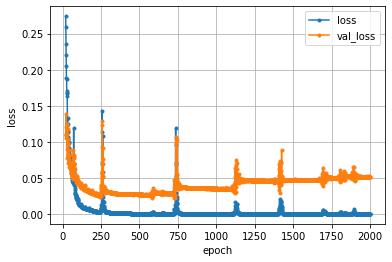

In [47]:
# 学習経過の可視化
loss     = history_2.history['loss']
val_loss = history_2.history['val_loss']

nb_epoch = len(loss)
for i in range(50):
  if max(loss)>0.3: 
    if i == 49:
      plt.plot(range(i,nb_epoch), loss, marker='.', label='loss')
      plt.plot(range(i,nb_epoch), val_loss, marker='.', label='val_loss')
      break
    else:
      loss = loss[1:]
      val_loss = val_loss[1:]
  else:
    plt.plot(range(i,nb_epoch), loss, marker='.', label='loss')
    plt.plot(range(i,nb_epoch), val_loss, marker='.', label='val_loss')
    break
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

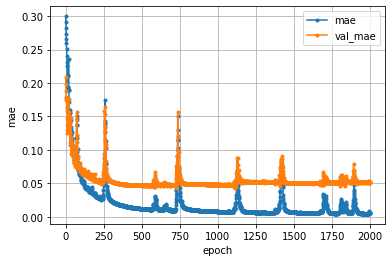

In [48]:
# 学習経過の可視化
mae     = history_2.history['mae']
val_mae = history_2.history['val_mae']

nb_epoch = len(mae)
for i in range(50):
  if max(mae)>0.3: 
    if i == 49:
      plt.plot(range(i,nb_epoch), mae, marker='.', label='mae')
      plt.plot(range(i,nb_epoch), val_mae, marker='.', label='val_mae')
      break
    else:
      mae = mae[1:]
      val_mae = val_mae[1:]
  else:
    plt.plot(range(i,nb_epoch), mae, marker='.', label='mae')
    plt.plot(range(i,nb_epoch), val_mae, marker='.', label='val_mae')
    break
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('mae')
plt.show()

In [49]:
# 学習モデルの保存
model_2.save(str(n)+"_random.seed("+str(seed)+")_train"+str(train)+"_raw.h5")

In [50]:
# model_3

# データの前処理


## 変数設定(各条件を変えてたくさん試すため)
train = 0.8                 #train:validのtrainデータの割合
seed = 1                       
random.seed(seed)           #乱数seed固定


## データ加工

### データ抽出(各データをランダムにシャッフル→train,valid,testに分割。各大きさのデータが同じ数だけ抽出される。)
for i in range (1,6):
  exec("lst_fs"+str(i)+"_shuffle = random.sample(lst_fs"+str(i)+", len(lst_fs"+str(i)+"))")  
  exec("lst_fs"+str(i)+"_train = lst_fs"+str(i)+"_shuffle[0:"+str(int(n/5*train))+"]")       
  exec("lst_fs"+str(i)+"_valid = lst_fs"+str(i)+"_shuffle["+str(int(n/5*train))+":"+str(int(n/5))+"]")          
  exec("lst_fs"+str(i)+"_test = lst_fs"+str(i)+"_shuffle["+str(int(n/5))+":-1]")
  exec("lst_fp"+str(i)+"_shuffle = random.sample(lst_fp"+str(i)+", len(lst_fp"+str(i)+"))")
  exec("lst_fp"+str(i)+"_train = lst_fp"+str(i)+"_shuffle[0:"+str(int(n/5*train))+"]")
  exec("lst_fp"+str(i)+"_valid = lst_fp"+str(i)+"_shuffle["+str(int(n/5*train))+":"+str(int(n/5))+"]") 
  exec("lst_fp"+str(i)+"_test = lst_fp"+str(i)+"_shuffle["+str(int(n/5))+":-1]")

### train,valid,testの各々について、大きさ、位置、表面温度分布データに分割
for i in range (1,6):
  exec("lst_x_fs"+str(i)+"_train = [r[0] for r in lst_fs"+str(i)+"_train]")
  exec("lst_x_fp"+str(i)+"_train = [r[0:2] for r in lst_fp"+str(i)+"_train]")
  exec("lst_y"+str(i)+"_train = [r[2:-1] for r in lst_fp"+str(i)+"_train]")
  exec("lst_x_fs"+str(i)+"_valid = [r[0] for r in lst_fs"+str(i)+"_valid]")
  exec("lst_x_fp"+str(i)+"_valid = [r[0:2] for r in lst_fp"+str(i)+"_valid]")
  exec("lst_y"+str(i)+"_valid = [r[2:-1] for r in lst_fp"+str(i)+"_valid]")
  exec("lst_x_fs"+str(i)+"_test = [r[0] for r in lst_fs"+str(i)+"_test]")
  exec("lst_x_fp"+str(i)+"_test = [r[0:2] for r in lst_fp"+str(i)+"_test]")
  exec("lst_y"+str(i)+"_test = [r[2:-1] for r in lst_fp"+str(i)+"_test]")

### データを結合(入力データ・正解データの大枠完成)
lst_x_fs_train = lst_x_fs1_train + lst_x_fs2_train + lst_x_fs3_train + lst_x_fs4_train + lst_x_fs5_train
lst_x_fp_train = lst_x_fp1_train + lst_x_fp2_train + lst_x_fp3_train + lst_x_fp4_train + lst_x_fp5_train
lst_y_train = lst_y1_train + lst_y2_train + lst_y3_train + lst_y4_train + lst_y5_train

lst_x_fs_valid = lst_x_fs1_valid + lst_x_fs2_valid + lst_x_fs3_valid + lst_x_fs4_valid + lst_x_fs5_valid
lst_x_fp_valid = lst_x_fp1_valid + lst_x_fp2_valid + lst_x_fp3_valid + lst_x_fp4_valid + lst_x_fp5_valid
lst_y_valid = lst_y1_valid + lst_y2_valid + lst_y3_valid + lst_y4_valid + lst_y5_valid

lst_x_fs_test = lst_x_fs1_test + lst_x_fs2_test + lst_x_fs3_test + lst_x_fs4_test + lst_x_fs5_test
lst_x_fp_test = lst_x_fp1_test + lst_x_fp2_test + lst_x_fp3_test + lst_x_fp4_test + lst_x_fp5_test
lst_y_test = lst_y1_test + lst_y2_test + lst_y3_test + lst_y4_test + lst_y5_test

### np.arrayで変換
lst_f0 = np.array(lst_f0, dtype=float)
lst_x_fs_train = np.array(lst_x_fs_train, dtype=int)
lst_x_fp_train = np.array(lst_x_fp_train, dtype=int)
lst_x_fs_valid = np.array(lst_x_fs_valid, dtype=int)
lst_x_fp_valid = np.array(lst_x_fp_valid, dtype=int)
lst_x_fs_test = np.array(lst_x_fs_test, dtype=int)
lst_x_fp_test = np.array(lst_x_fp_test, dtype=int)
lst_y_train = np.array(lst_y_train, dtype=float)
lst_y_valid = np.array(lst_y_valid, dtype=float)
lst_y_test = np.array(lst_y_test, dtype=float)

### 入力データを二次元化
x_fs_train = lst_x_fs_train.reshape(-1, 1)
x_fs_valid = lst_x_fs_valid.reshape(-1, 1)
x_fs_test = lst_x_fs_test.reshape(-1, 1)

### 温度分布データを、穴なし温度分布データとの差に変換
y_train = lst_y_train - lst_f0
y_valid = lst_y_valid - lst_f0
y_test = lst_y_test - lst_f0

### 入力データの正規化
scaler_x = MinMaxScaler()
x_fs_train_n = scaler_x.fit_transform(x_fs_train)
x_fs_valid_n = scaler_x.fit_transform(x_fs_valid)
x_fs_test_n = scaler_x.fit_transform(x_fs_test) 
x_fp_train_n = scaler_x.fit_transform(lst_x_fp_train)
x_fp_valid_n = scaler_x.fit_transform(lst_x_fp_valid)
x_fp_test_n = scaler_x.fit_transform(lst_x_fp_test) 

In [51]:
# NN

## 入力を定義
input1 = Input(shape=(1,))
input2 = Input(shape=(2,))

## 入力1から結合前まで
x = Dense(1, activation="linear")(input1)
x = Model(inputs=input1, outputs=x)

## 入力2から結合前まで
y = Dense(2, activation="linear")(input2)
y = Model(inputs=input2, outputs=y)

## 結合
combined = concatenate([x.output, y.output])

## 密結合
z = Dense(32, activation="relu")(combined)
z = Dense(512, activation="relu")(z)
z = Dense(256, activation="relu")(z)
z = Dense(128, activation="relu")(z)
z = Dense(50)(z)

## モデル定義とコンパイル
model_3 = Model(inputs=[x.input, y.input], outputs=z)
model_3.compile(loss='mse', optimizer='adam', metrics=['mae'])

In [52]:
# 学習
epochs = 2000
batch_size = 32
history_3 = model_3.fit([x_fs_train_n, x_fp_train_n], y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=([x_fs_valid_n, x_fp_valid_n], y_valid))

Epoch 1/2000
7/7 [==============================] - 1s 38ms/step - loss: 0.2810 - mae: 0.2543 - val_loss: 0.1304 - val_mae: 0.1728
Epoch 2/2000
7/7 [==============================] - 0s 12ms/step - loss: 0.3327 - mae: 0.2392 - val_loss: 0.1181 - val_mae: 0.1604
Epoch 3/2000
7/7 [==============================] - 0s 12ms/step - loss: 0.1914 - mae: 0.1855 - val_loss: 0.1138 - val_mae: 0.1382
Epoch 4/2000
7/7 [==============================] - 0s 12ms/step - loss: 0.2837 - mae: 0.1786 - val_loss: 0.1136 - val_mae: 0.1475
Epoch 5/2000
7/7 [==============================] - 0s 11ms/step - loss: 0.1496 - mae: 0.1526 - val_loss: 0.1138 - val_mae: 0.1438
Epoch 6/2000
7/7 [==============================] - 0s 10ms/step - loss: 0.1357 - mae: 0.1481 - val_loss: 0.1057 - val_mae: 0.1319
Epoch 7/2000
7/7 [==============================] - 0s 11ms/step - loss: 0.2956 - mae: 0.1750 - val_loss: 0.1083 - val_mae: 0.1355
Epoch 8/2000
7/7 [==============================] - 0s 10ms/step - loss: 0.1874 - m

In [53]:
# モデルの評価
score = model_3.evaluate([x_fs_test_n, x_fp_test_n], y_test, verbose=1)
print('Test loss:', score[0])
print('Test mae:', score[1])

309/309 [==============================] - 0s 2ms/step - loss: 0.0891 - mae: 0.0547
Test loss: 0.08906733989715576
Test mae: 0.05471746250987053


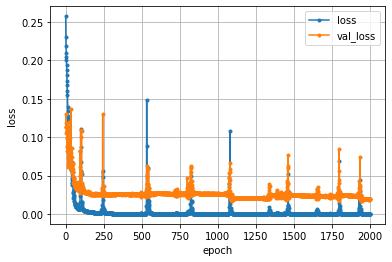

In [54]:
# 学習経過の可視化
loss     = history_3.history['loss']
val_loss = history_3.history['val_loss']

nb_epoch = len(loss)
for i in range(50):
  if max(loss)>0.3: 
    if i == 49:
      plt.plot(range(i,nb_epoch), loss, marker='.', label='loss')
      plt.plot(range(i,nb_epoch), val_loss, marker='.', label='val_loss')
      break
    else:
      loss = loss[1:]
      val_loss = val_loss[1:]
  else:
    plt.plot(range(i,nb_epoch), loss, marker='.', label='loss')
    plt.plot(range(i,nb_epoch), val_loss, marker='.', label='val_loss')
    break
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

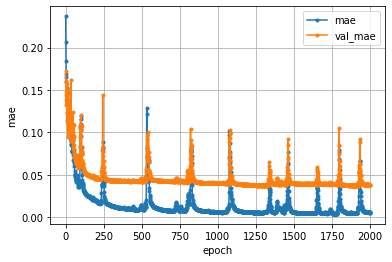

In [55]:
# 学習経過の可視化
mae     = history_3.history['mae']
val_mae = history_3.history['val_mae']

nb_epoch = len(mae)
for i in range(50):
  if max(mae)>0.3: 
    if i == 49:
      plt.plot(range(i,nb_epoch), mae, marker='.', label='mae')
      plt.plot(range(i,nb_epoch), val_mae, marker='.', label='val_mae')
      break
    else:
      mae = mae[1:]
      val_mae = val_mae[1:]
  else:
    plt.plot(range(i,nb_epoch), mae, marker='.', label='mae')
    plt.plot(range(i,nb_epoch), val_mae, marker='.', label='val_mae')
    break
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('mae')
plt.show()

In [56]:
# 学習モデルの保存
model_3.save(str(n)+"_random.seed("+str(seed)+")_train"+str(train)+"_raw.h5")

In [57]:
# model_4

# データの前処理


## 変数設定(各条件を変えてたくさん試すため)
train = 0.5                 #train:validのtrainデータの割合                       
random.seed(seed)           #乱数seed固定


## データ加工

### データ抽出(各データをランダムにシャッフル→train,valid,testに分割。各大きさのデータが同じ数だけ抽出される。)
for i in range (1,6):
  exec("lst_fs"+str(i)+"_shuffle = random.sample(lst_fs"+str(i)+", len(lst_fs"+str(i)+"))")  
  exec("lst_fs"+str(i)+"_train = lst_fs"+str(i)+"_shuffle[0:"+str(int(n/5*train))+"]")       
  exec("lst_fs"+str(i)+"_valid = lst_fs"+str(i)+"_shuffle["+str(int(n/5*train))+":"+str(int(n/5))+"]")          
  exec("lst_fs"+str(i)+"_test = lst_fs"+str(i)+"_shuffle["+str(int(n/5))+":-1]")
  exec("lst_fp"+str(i)+"_shuffle = random.sample(lst_fp"+str(i)+", len(lst_fp"+str(i)+"))")
  exec("lst_fp"+str(i)+"_train = lst_fp"+str(i)+"_shuffle[0:"+str(int(n/5*train))+"]")
  exec("lst_fp"+str(i)+"_valid = lst_fp"+str(i)+"_shuffle["+str(int(n/5*train))+":"+str(int(n/5))+"]") 
  exec("lst_fp"+str(i)+"_test = lst_fp"+str(i)+"_shuffle["+str(int(n/5))+":-1]")

### train,valid,testの各々について、大きさ、位置、表面温度分布データに分割
for i in range (1,6):
  exec("lst_x_fs"+str(i)+"_train = [r[0] for r in lst_fs"+str(i)+"_train]")
  exec("lst_x_fp"+str(i)+"_train = [r[0:2] for r in lst_fp"+str(i)+"_train]")
  exec("lst_y"+str(i)+"_train = [r[2:-1] for r in lst_fp"+str(i)+"_train]")
  exec("lst_x_fs"+str(i)+"_valid = [r[0] for r in lst_fs"+str(i)+"_valid]")
  exec("lst_x_fp"+str(i)+"_valid = [r[0:2] for r in lst_fp"+str(i)+"_valid]")
  exec("lst_y"+str(i)+"_valid = [r[2:-1] for r in lst_fp"+str(i)+"_valid]")
  exec("lst_x_fs"+str(i)+"_test = [r[0] for r in lst_fs"+str(i)+"_test]")
  exec("lst_x_fp"+str(i)+"_test = [r[0:2] for r in lst_fp"+str(i)+"_test]")
  exec("lst_y"+str(i)+"_test = [r[2:-1] for r in lst_fp"+str(i)+"_test]")

### データを結合(入力データ・正解データの大枠完成)
lst_x_fs_train = lst_x_fs1_train + lst_x_fs2_train + lst_x_fs3_train + lst_x_fs4_train + lst_x_fs5_train
lst_x_fp_train = lst_x_fp1_train + lst_x_fp2_train + lst_x_fp3_train + lst_x_fp4_train + lst_x_fp5_train
lst_y_train = lst_y1_train + lst_y2_train + lst_y3_train + lst_y4_train + lst_y5_train

lst_x_fs_valid = lst_x_fs1_valid + lst_x_fs2_valid + lst_x_fs3_valid + lst_x_fs4_valid + lst_x_fs5_valid
lst_x_fp_valid = lst_x_fp1_valid + lst_x_fp2_valid + lst_x_fp3_valid + lst_x_fp4_valid + lst_x_fp5_valid
lst_y_valid = lst_y1_valid + lst_y2_valid + lst_y3_valid + lst_y4_valid + lst_y5_valid

lst_x_fs_test = lst_x_fs1_test + lst_x_fs2_test + lst_x_fs3_test + lst_x_fs4_test + lst_x_fs5_test
lst_x_fp_test = lst_x_fp1_test + lst_x_fp2_test + lst_x_fp3_test + lst_x_fp4_test + lst_x_fp5_test
lst_y_test = lst_y1_test + lst_y2_test + lst_y3_test + lst_y4_test + lst_y5_test

### np.arrayで変換
lst_f0 = np.array(lst_f0, dtype=float)
lst_x_fs_train = np.array(lst_x_fs_train, dtype=int)
lst_x_fp_train = np.array(lst_x_fp_train, dtype=int)
lst_x_fs_valid = np.array(lst_x_fs_valid, dtype=int)
lst_x_fp_valid = np.array(lst_x_fp_valid, dtype=int)
lst_x_fs_test = np.array(lst_x_fs_test, dtype=int)
lst_x_fp_test = np.array(lst_x_fp_test, dtype=int)
lst_y_train = np.array(lst_y_train, dtype=float)
lst_y_valid = np.array(lst_y_valid, dtype=float)
lst_y_test = np.array(lst_y_test, dtype=float)

### 入力データを二次元化
x_fs_train = lst_x_fs_train.reshape(-1, 1)
x_fs_valid = lst_x_fs_valid.reshape(-1, 1)
x_fs_test = lst_x_fs_test.reshape(-1, 1)

### 温度分布データを、穴なし温度分布データとの差に変換
y_train = lst_y_train - lst_f0
y_valid = lst_y_valid - lst_f0
y_test = lst_y_test - lst_f0

### 入力データの正規化
scaler_x = MinMaxScaler()
x_fs_train_n = scaler_x.fit_transform(x_fs_train)
x_fs_valid_n = scaler_x.fit_transform(x_fs_valid)
x_fs_test_n = scaler_x.fit_transform(x_fs_test) 
x_fp_train_n = scaler_x.fit_transform(lst_x_fp_train)
x_fp_valid_n = scaler_x.fit_transform(lst_x_fp_valid)
x_fp_test_n = scaler_x.fit_transform(lst_x_fp_test) 

In [58]:
# NN

## 入力を定義
input1 = Input(shape=(1,))
input2 = Input(shape=(2,))

## 入力1から結合前まで
x = Dense(1, activation="linear")(input1)
x = Model(inputs=input1, outputs=x)

## 入力2から結合前まで
y = Dense(2, activation="linear")(input2)
y = Model(inputs=input2, outputs=y)

## 結合
combined = concatenate([x.output, y.output])

## 密結合
z = Dense(32, activation="relu")(combined)
z = Dense(512, activation="relu")(z)
z = Dense(256, activation="relu")(z)
z = Dense(128, activation="relu")(z)
z = Dense(50)(z)

## モデル定義とコンパイル
model_4 = Model(inputs=[x.input, y.input], outputs=z)
model_4.compile(loss='mse', optimizer='adam', metrics=['mae'])

In [59]:
# 学習
epochs = 2000
batch_size = 32
history_4 = model_4.fit([x_fs_train_n, x_fp_train_n], y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=([x_fs_valid_n, x_fp_valid_n], y_valid))

Epoch 1/2000
4/4 [==============================] - 1s 71ms/step - loss: 0.1839 - mae: 0.2277 - val_loss: 0.2556 - val_mae: 0.2049
Epoch 2/2000
4/4 [==============================] - 0s 18ms/step - loss: 0.1707 - mae: 0.2070 - val_loss: 0.2562 - val_mae: 0.2089
Epoch 3/2000
4/4 [==============================] - 0s 19ms/step - loss: 0.1442 - mae: 0.1892 - val_loss: 0.2460 - val_mae: 0.1884
Epoch 4/2000
4/4 [==============================] - 0s 18ms/step - loss: 0.1072 - mae: 0.1589 - val_loss: 0.2406 - val_mae: 0.1755
Epoch 5/2000
4/4 [==============================] - 0s 18ms/step - loss: 0.2383 - mae: 0.1935 - val_loss: 0.2331 - val_mae: 0.1655
Epoch 6/2000
4/4 [==============================] - 0s 25ms/step - loss: 0.2066 - mae: 0.1709 - val_loss: 0.2291 - val_mae: 0.1657
Epoch 7/2000
4/4 [==============================] - 0s 20ms/step - loss: 0.1264 - mae: 0.1419 - val_loss: 0.2213 - val_mae: 0.1552
Epoch 8/2000
4/4 [==============================] - 0s 19ms/step - loss: 0.0817 - m

In [60]:
# モデルの評価
score = model_4.evaluate([x_fs_test_n, x_fp_test_n], y_test, verbose=1)
print('Test loss:', score[0])
print('Test mae:', score[1])

309/309 [==============================] - 0s 2ms/step - loss: 0.1417 - mae: 0.0688
Test loss: 0.14173249900341034
Test mae: 0.06884391605854034


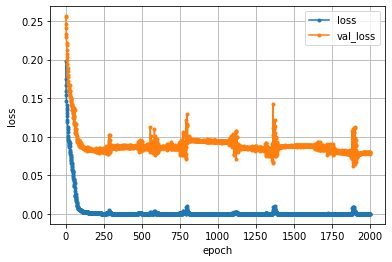

In [61]:
# 学習経過の可視化
loss     = history_4.history['loss']
val_loss = history_4.history['val_loss']

nb_epoch = len(loss)
for i in range(50):
  if max(loss)>0.3: 
    if i == 49:
      plt.plot(range(i,nb_epoch), loss, marker='.', label='loss')
      plt.plot(range(i,nb_epoch), val_loss, marker='.', label='val_loss')
      break
    else:
      loss = loss[1:]
      val_loss = val_loss[1:]
  else:
    plt.plot(range(i,nb_epoch), loss, marker='.', label='loss')
    plt.plot(range(i,nb_epoch), val_loss, marker='.', label='val_loss')
    break
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

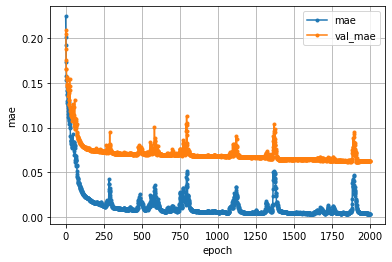

In [62]:
# 学習経過の可視化
mae     = history_4.history['mae']
val_mae = history_4.history['val_mae']

nb_epoch = len(mae)
for i in range(50):
  if max(mae)>0.3: 
    if i == 49:
      plt.plot(range(i,nb_epoch), mae, marker='.', label='mae')
      plt.plot(range(i,nb_epoch), val_mae, marker='.', label='val_mae')
      break
    else:
      mae = mae[1:]
      val_mae = val_mae[1:]
  else:
    plt.plot(range(i,nb_epoch), mae, marker='.', label='mae')
    plt.plot(range(i,nb_epoch), val_mae, marker='.', label='val_mae')
    break
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('mae')
plt.show()

In [63]:
# 学習モデルの保存
model_4.save(str(n)+"_random.seed("+str(seed)+")_train"+str(train)+"_raw.h5")